In [1]:
import pandas as pd
from tqdm import tqdm
import inflect
import re
p = inflect.engine()
import copy
import nltk
from nltk.corpus import stopwords
from bertopic import BERTopic
import string



In [2]:
patient_notes = pd.read_csv("data/nbme-score-clinical-patient-notes/patient_notes.csv")

In [3]:
patient_notes

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...
...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...


In [4]:
patient_notes['pn_history'].iloc[4]

'17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently "beat out of his chest," with some associated difficulty catching his breath. States that the most recent event was 2 days ago, and during activity at a soccer game. He does not seem to note any specific precipitatinig factors at this time. He also states that he feels as if he will faint during these events, but has not lost consciousness at any point. Furthermore, he does endorse theses attacks occuring 1-2 times a month and peak at 4 mins. He denies any stressors at home. ROS: denies weight loss, fevers, recnet illness, change in bowel habits. PMH: negative, PSH negative, FHX mom with thyroid disorder, dad with heart condition and MI at 52yo. SHX no tobacco, ETOH on weekends, Marijuana tried a month ago. Med: is taking some of roommates Adderoll intermittently (last was 2 days ago prior to event). KNDA'

In [5]:
def convert_number_to_word(patient_notes):
    transformed_notes = []
    for i,note in tqdm(enumerate(patient_notes.pn_history),total=len(patient_notes)):
        list_numbers=re.findall(r'[0-9]+', note)
        list_numbers=[int(l) for l in list_numbers]
        list_words=[p.number_to_words(l)  for l in list_numbers]
        dict_NW=dict(zip(list_numbers,list_words))
        myKeys = list(dict_NW.keys())
        myKeys.sort(reverse=True)
        sorted_dict = {i: dict_NW[i] for i in myKeys}
        ans=copy.copy(note)
        for key in sorted_dict.keys():
            ans=re.sub(str(key),' '+sorted_dict[key]+' ',ans)
        transformed_notes.append(ans) 
    return transformed_notes

Converting a number to text to avoid topic seperation from people belonging to different ages and numbers are removed from the data anyways

In [6]:
patient_notes_converted = convert_number_to_word(patient_notes)

100%|██████████████████████████████████████████████████████| 42146/42146 [00:07<00:00, 5756.47it/s]


In [7]:
patient_notes.pn_history.iloc[4]

'17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently "beat out of his chest," with some associated difficulty catching his breath. States that the most recent event was 2 days ago, and during activity at a soccer game. He does not seem to note any specific precipitatinig factors at this time. He also states that he feels as if he will faint during these events, but has not lost consciousness at any point. Furthermore, he does endorse theses attacks occuring 1-2 times a month and peak at 4 mins. He denies any stressors at home. ROS: denies weight loss, fevers, recnet illness, change in bowel habits. PMH: negative, PSH negative, FHX mom with thyroid disorder, dad with heart condition and MI at 52yo. SHX no tobacco, ETOH on weekends, Marijuana tried a month ago. Med: is taking some of roommates Adderoll intermittently (last was 2 days ago prior to event). KNDA'

In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"yo", " year old ", phrase)

    return phrase

contractions = {
"he's": "he is",
"how's": "how is",
"it's": "it is",
"let's": "let us",
"she's": "she is",
"so's": "so is",
"there's": "there is",
"what's": "what is",
"when's": "when is",
"where's": "where is",
"why's": "why is",
}

def remove_punctuation(text):
    punctuationfree="".join([i if i not in string.punctuation else ' ' for i in text ])
    return punctuationfree

def cleantextdata(patient_list):
    flat_list=[re.sub(r'[0-9]+', '', s) for s in patient_list]
    flat_list=[re.sub('\t', ' ', s) for s in flat_list]
    flat_list=[re.sub('  ', ' ', s) for s in flat_list]
    flat_list=[decontracted(x) for x in flat_list]
    l=[]
    from tqdm import tqdm
    for sent in tqdm(flat_list,total=len(flat_list)):
        for cont in contractions.keys():
            sent=re.sub(cont,contractions[cont],sent)
        l.append(sent)
    flat_list=copy.deepcopy(l)
    flat_list=[f.strip() for f in flat_list]
    flat_list=[re.sub(r"[,.;@#?!&$/:-<+–…’-]+\ *", " ",x) for x in flat_list]
    flat_list=[remove_punctuation(f) for f in flat_list]
    flat_list=[re.sub('[^A-Za-z0-9 ]+', '', f) for f in flat_list]
    flat_list=[x.lower() for x in flat_list]
    flat_list=[f.strip() for f in flat_list]
    
    
    return flat_list
    

decontraction of apostophe

In [28]:
patient_notes_converted = cleantextdata(patient_notes_converted)

100%|█████████████████████████████████████████████████████| 42146/42146 [00:00<00:00, 62136.40it/s]


In [29]:

#Remove stop words
stop=stopwords.words('english')

patient_notes_converted = [' '.join([word for word in x.split() if word not in stop]) for x in patient_notes_converted]


Removal of stopwords

In [32]:
patient_notes_subset = patient_notes_converted[:int(len(patient_notes_converted)*0.05)]

In [39]:

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(patient_notes_converted)

Batches:   0%|          | 0/1318 [00:00<?, ?it/s]

2023-01-23 11:13:27,141 - BERTopic - Transformed documents to Embeddings
2023-01-23 11:14:03,334 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-01-23 11:14:12,508 - BERTopic - Clustered reduced embeddings


In [40]:
topic_model.save("my_model_full")


In [50]:
topic_model = BERTopic.load("my_model_full")

In [ ]:
topic_model.save("my_model")


In [51]:
freq = topic_model.get_topic_info(); freq

,Topic,Count,Name
0,-1,3530,-1_episodes_ago_palpitations_none
1,0,5400,0_nervousness_forty_english_professor
2,1,5153,1_headache_yesterday_dull_head
3,2,4168,2_pain_tums_motrin_epigastric
4,3,4112,3_periods_months_six_cancer
...,...,...,...
56,55,12,55_peroids_peroid_irregular_discharge
57,56,11,56_pain_mr_tums_hamiliton
58,57,11,57_smith_verbal_examination_consent
59,58,10,58_pounding_adderall_heart_seventeen


In [52]:
topic_model.get_topic(0)  # Select the most frequent topic

[('nervousness', 0.034075357768236954),
 ('forty', 0.024200746829825388),
 ('english', 0.019453404664793134),
 ('professor', 0.019433752234653583),
 ('husband', 0.01753649958613261),
 ('asleep', 0.016846218302815654),
 ('lectures', 0.016616619224852917),
 ('care', 0.016349893376944445),
 ('falling', 0.01575287712353058),
 ('tylenol', 0.015750924770890087)]

In [53]:
topic_model.topics_[:10]

[-1, -1, 21, -1, -1, 18, 15, -1, 40, -1]

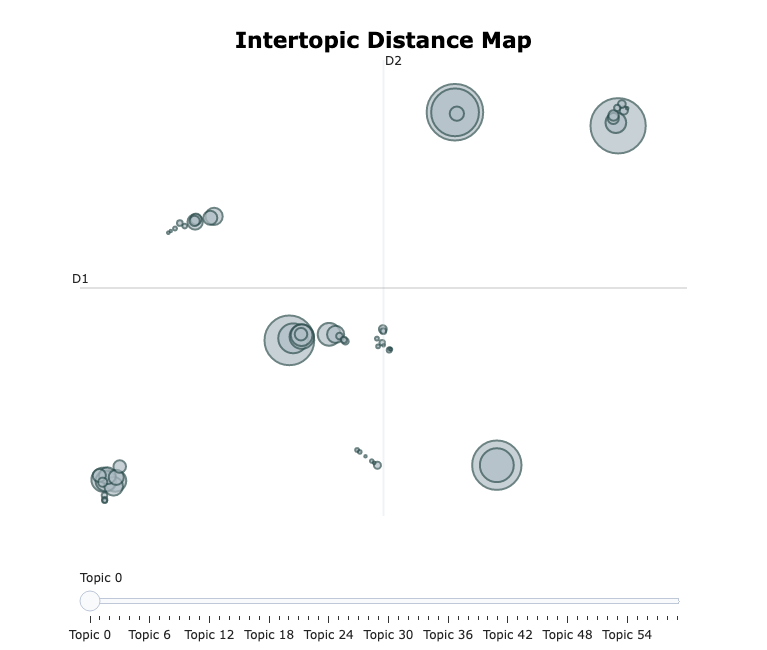

In [54]:
topic_model.visualize_topics()

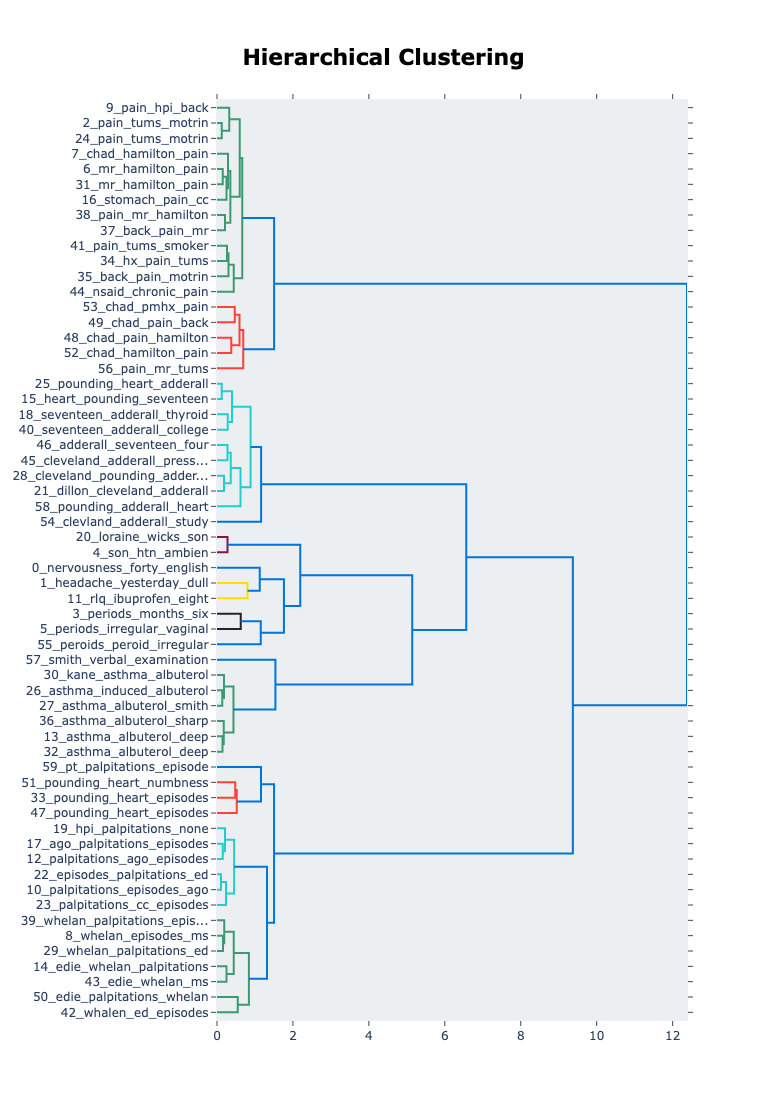

In [55]:
topic_model.visualize_hierarchy(top_n_topics=60)

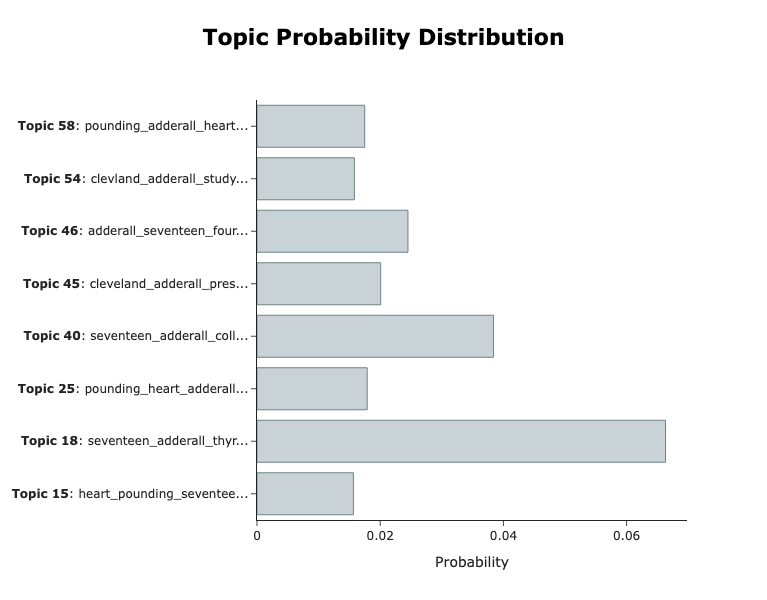

In [56]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

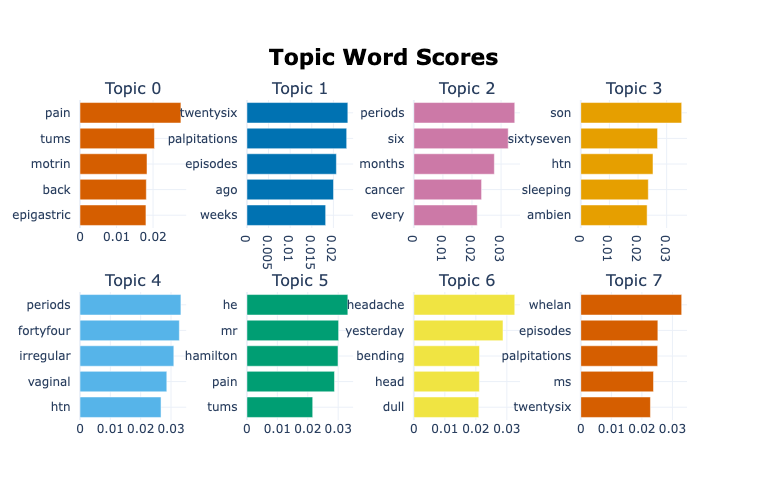

In [22]:
topic_model.visualize_barchart(top_n_topics=8)

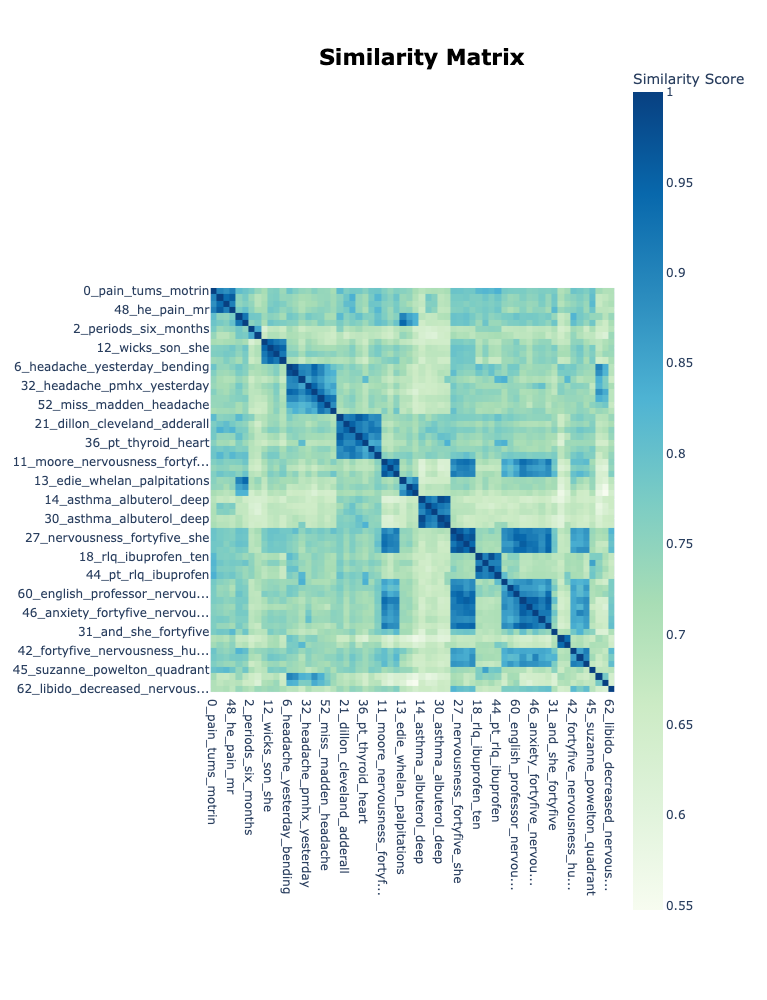

In [23]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

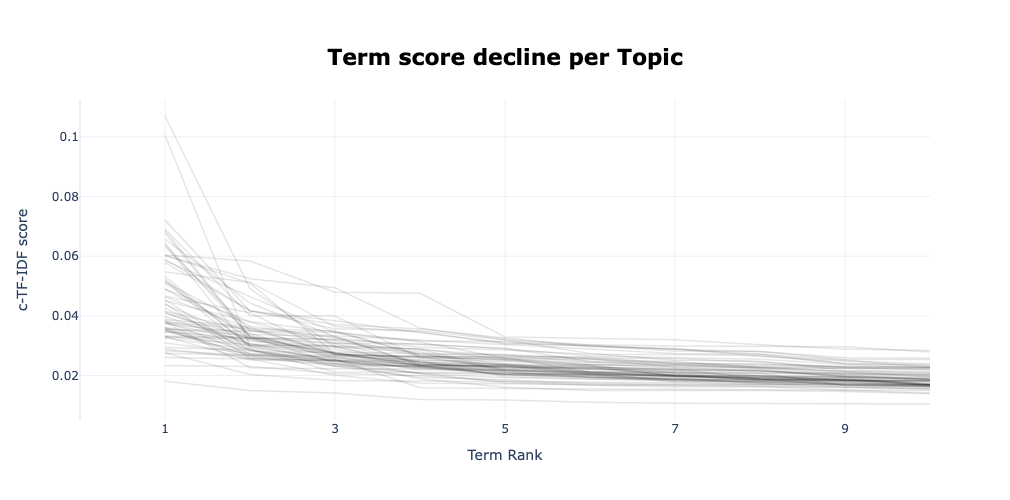

In [24]:
topic_model.visualize_term_rank()

In [25]:
freq = topic_model.get_topic_info(); 


In [26]:
freq

,Topic,Count,Name
0,-1,3837,-1_nervousness_fortyfive_tylenol_she
1,0,6774,0_pain_tums_motrin_back
2,1,4728,1_twentysix_palpitations_episodes_ago
3,2,4126,2_periods_six_months_cancer
4,3,2969,3_son_sixtyseven_htn_sleeping
...,...,...,...
60,59,14,59_headache_madden_ms_migraines
61,60,12,60_english_professor_nervousness_fortyfive
62,61,11,61_overwhelmed_she_anxiety_feels
63,62,11,62_libido_decreased_nervousness_fortyfive


In [46]:
topic_model.reduce_topics(patient_notes_converted, nr_topics=30)

2023-01-23 11:20:53,980 - BERTopic - Reduced number of topics from 61 to 31


In [47]:
freq = topic_model.get_topic_info(); 
freq

,Topic,Count,Name
0,-1,3530,-1_ago_none_two_episodes
1,0,5400,0_nervousness_forty_english_professor
2,1,5153,1_headache_yesterday_dull_three
3,2,4292,2_pain_two_tums_one
4,3,4112,3_periods_months_six_cancer
5,4,3854,4_son_htn_sleeping_ambien
6,5,1946,5_periods_irregular_vaginal_htn
7,6,1737,6_pain_mr_hamilton_tums
8,7,1094,7_whelan_episodes_palpitations_ms
9,8,1079,8_chad_pain_hamilton_two


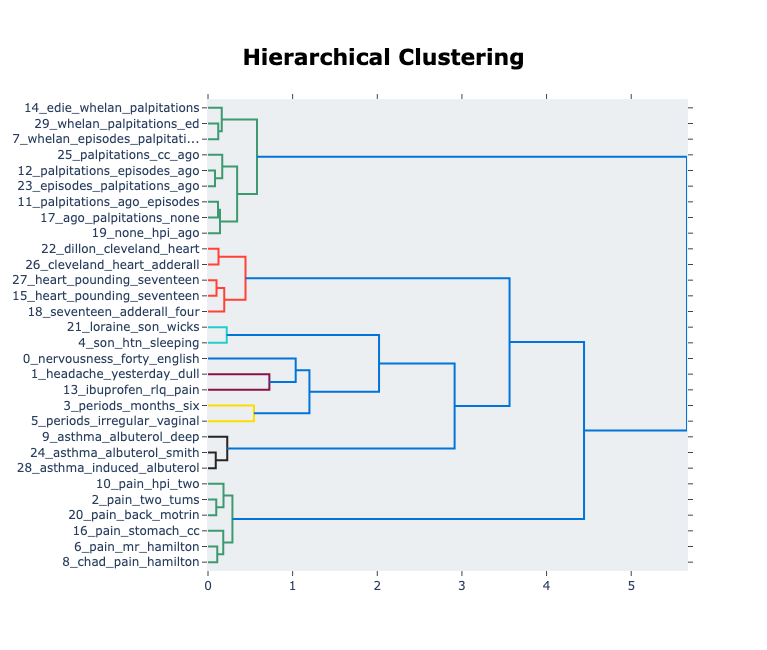

In [48]:
topic_model.visualize_hierarchy(top_n_topics=30)